# Sistema de Recomendação de Filmes com Filtragem Colaborativa (KNN)
https://github.com/wandramdias/TP_ApMaq 

O objetivo deste projeto é desenvolver um sistema de recomendação de filmes baseado no método de filtragem colaborativa (User-Based).
O dataset utilizado é o MovieLens (ml-latest-small), contendo avaliações, tags e informações de filmes.

## ETAPA 1 - Importação das bibliotecas e carregamento dos dados

Aqui carregamos os arquivos CSV e fizemos uma inspeção inicial das tabelas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

# Carregar datasets
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")
tags = pd.read_csv("tags.csv")

# Visualizar primeiras linhas
print("📘 Avaliações (ratings.csv):")
print(ratings.head(), "\n")

print("🎬 Filmes (movies.csv):")
print(movies.head(), "\n")

print("🏷️ Tags (tags.csv):")
print(tags.head(), "\n")

# Tamanhos
print("Tamanhos:")
print("ratings:", ratings.shape)
print("movies:", movies.shape)
print("tags:", tags.shape)


📘 Avaliações (ratings.csv):
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

🎬 Filmes (movies.csv):
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

🏷️ Tags (tags.csv):
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1     

##  ETAPA 2 - Tratamento e limpeza dos dados

Garantimos que não há valores ausentes e preparamos os dados para análise exploratória.

In [2]:
# Verificar valores ausentes
print("Valores ausentes por tabela:")
print(ratings.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())

# Converter timestamp para datetime (facilita análises temporais)
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')

# Estatísticas básicas das avaliações
print("Estatísticas das notas:")
print(ratings['rating'].describe())

# Número de usuários e filmes únicos
print(f"Usuários únicos: {ratings['userId'].nunique()}")
print(f"Filmes únicos: {ratings['movieId'].nunique()}")

# Distribuição de gêneros
all_genres = movies['genres'].str.split('|').explode().value_counts()
print("Top 10 gêneros mais frequentes:")
display(all_genres.head(10))


Valores ausentes por tabela:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
Estatísticas das notas:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64
Usuários únicos: 610
Filmes únicos: 9724
Top 10 gêneros mais frequentes:


,count
genres,
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978


##  ETAPA 3 - Visualizações exploratórias

Com essas visualizações, entendemos como os usuários interagem com os filmes e a popularidade dos gêneros.

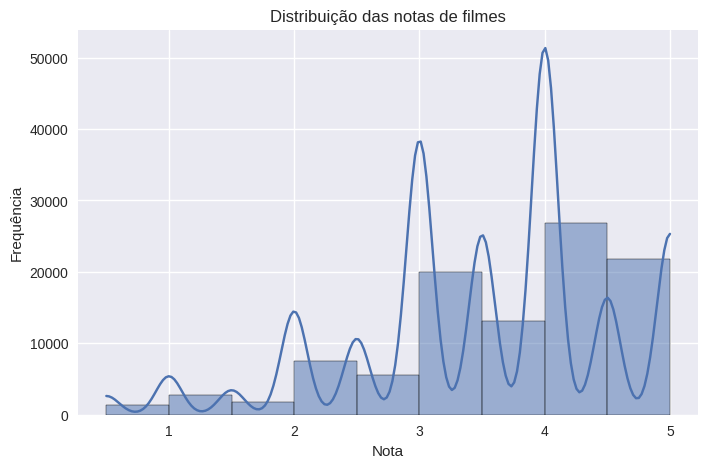

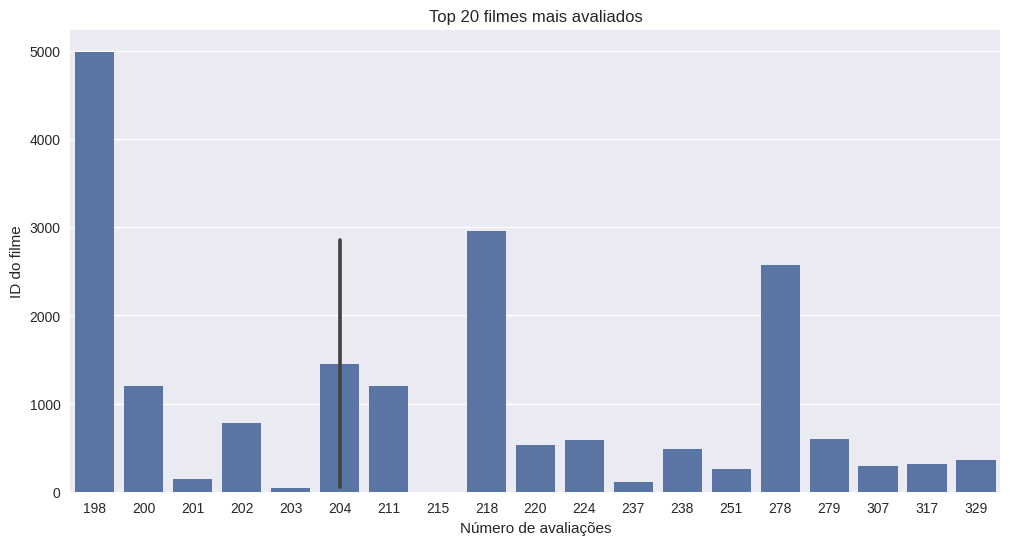

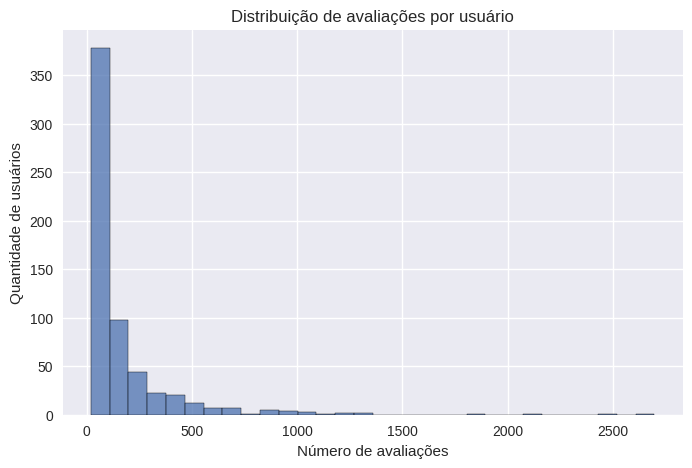

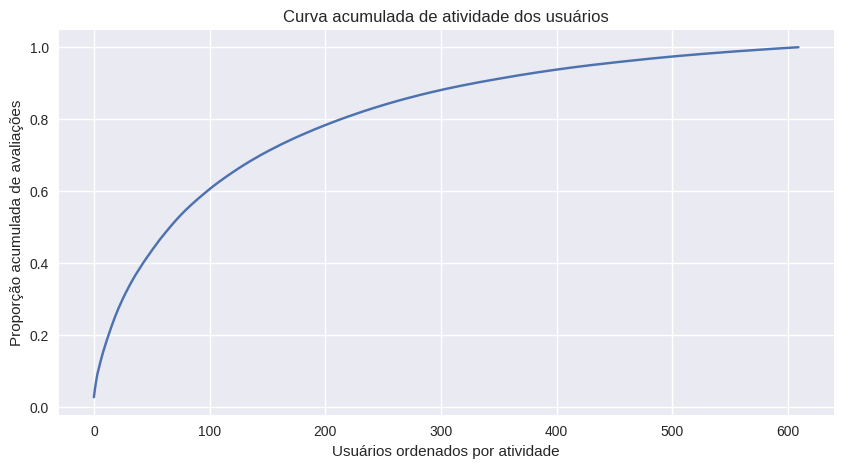

35.08% dos usuários geram 80% das avaliações.


In [3]:
plt.style.use('seaborn-v0_8')

# 1️⃣ Distribuição das notas
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=9, kde=True)
plt.title("Distribuição das notas de filmes")
plt.xlabel("Nota")
plt.ylabel("Frequência")
plt.show()

# 2️⃣ Top 20 filmes mais avaliados
top_movies = ratings['movieId'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_movies.values, y=top_movies.index)
plt.title("Top 20 filmes mais avaliados")
plt.xlabel("Número de avaliações")
plt.ylabel("ID do filme")
plt.show()

# 3️⃣ Distribuição do número de avaliações por usuário
ratings_per_user = ratings['userId'].value_counts()
plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user, bins=30, kde=False)
plt.title("Distribuição de avaliações por usuário")
plt.xlabel("Número de avaliações")
plt.ylabel("Quantidade de usuários")
plt.show()

# 4️⃣ Curva acumulada de atividade dos usuários
sorted_activity = ratings_per_user.sort_values(ascending=False).values
cum_sum = np.cumsum(sorted_activity) / sorted_activity.sum()
plt.figure(figsize=(10,5))
plt.plot(cum_sum)
plt.xlabel('Usuários ordenados por atividade')
plt.ylabel('Proporção acumulada de avaliações')
plt.title('Curva acumulada de atividade dos usuários')
plt.grid(True)
plt.show()

percent_80 = np.argmax(cum_sum >= 0.8) / len(cum_sum) * 100
print(f"{percent_80:.2f}% dos usuários geram 80% das avaliações.")


##  ETAPA 4 - Análise de atividade dos usuários

Observamos comportamento típico de dados reais: poucos usuários ativos geram a maior parte das avaliações (cauda longa).

In [4]:
# Criar matriz usuário-item
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# Estatísticas de filmes
movie_stats = ratings.groupby('movieId').agg({'rating': ['count','mean']})
movie_stats.columns = ['rating_count', 'rating_mean']
movie_stats = movie_stats.sort_values(by='rating_count', ascending=False)

# Calcular sparsidade
total_elements = user_item_matrix.shape[0] * user_item_matrix.shape[1]
filled_elements = user_item_matrix.count().sum()
sparsity = 1 - (filled_elements / total_elements)
print(f"Sparsidade da matriz: {sparsity:.4%}")

# Filtrar usuários e filmes ativos
min_user_ratings = 30
min_movie_ratings = 30
active_users = ratings.groupby('userId').filter(lambda x: len(x) >= min_user_ratings)
active_movies = active_users.groupby('movieId').filter(lambda x: len(x) >= min_movie_ratings)

# Nova matriz filtrada
filtered_matrix = active_movies.pivot_table(index='userId', columns='movieId', values='rating')
print(f"Tamanho da matriz filtrada: {filtered_matrix.shape}")

# Sparsidade após filtragem
total_elements = filtered_matrix.shape[0] * filtered_matrix.shape[1]
filled_elements = filtered_matrix.count().sum()
sparsity_filtered = 1 - (filled_elements / total_elements)
print(f"Sparsidade após filtragem: {sparsity_filtered:.4%}")


Sparsidade da matriz: 98.3000%
Tamanho da matriz filtrada: (501, 860)
Sparsidade após filtragem: 87.1348%


## ETAPA 5 - Treinamento do modelo KNN User-Based

In [5]:
# Substituir NaN por 0
filtered_matrix_filled = filtered_matrix.fillna(0)

# Treinar modelo KNN baseado em similaridade de usuários
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(filtered_matrix_filled.values)


NearestNeighbors(algorithm='brute', metric='cosine')

## ETAPA 6 - Função de recomendação de filmes

In [6]:
def recomendar_filmes_knn(user_id, num_recomendacoes=5):
    """
    Retorna recomendações de filmes para um usuário usando KNN User-Based.
    """
    if user_id not in filtered_matrix_filled.index:
        print(f"Usuário {user_id} não está na base filtrada.")
        return pd.DataFrame()

    # Vetor do usuário
    user_index = filtered_matrix_filled.index.get_loc(user_id)
    user_vector = filtered_matrix_filled.iloc[user_index, :].values.reshape(1, -1)

    # Encontrar vizinhos mais próximos
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=6)
    similar_users = indices.flatten()[1:]  # Ignora ele mesmo

    # Filmes já assistidos pelo usuário
    user_ratings = filtered_matrix_filled.loc[user_id]
    watched_movies = user_ratings[user_ratings > 0].index.tolist()

    # Média das notas dos vizinhos
    neighbor_ratings = filtered_matrix_filled.iloc[similar_users]
    mean_ratings = neighbor_ratings.mean(axis=0)

    # Recomendar filmes não assistidos
    recommendations = mean_ratings.drop(watched_movies).sort_values(ascending=False).head(num_recomendacoes)

    return movies[movies['movieId'].isin(recommendations.index)][['title', 'genres']]

# Teste
print("🎯 Recomendações para o usuário 414:")
display(recomendar_filmes_knn(414, num_recomendacoes=5))


🎯 Recomendações para o usuário 414:


,title,genres
455,Robin Hood: Men in Tights (1993),Comedy
920,Psycho (1960),Crime|Horror
957,"Shining, The (1980)",Horror
2743,For a Few Dollars More (Per qualche dollaro in...,Action|Drama|Thriller|Western
6310,Borat: Cultural Learnings of America for Make ...,Comedy


## ETAPA 7 - Avaliação do modelo com RMSE

In [7]:
# Dividir dados em treino e teste
train_data, test_data = train_test_split(active_movies, test_size=0.2, random_state=42)

# Reconstruir matriz de treino
train_matrix = train_data.pivot_table(index='userId', columns='movieId', values='rating')
train_matrix = train_matrix.reindex(index=filtered_matrix.index, columns=filtered_matrix.columns).fillna(0)

# Treinar modelo KNN
model_knn.fit(train_matrix.values)

# Função para prever nota
def prever_nota_knn(user_id, movie_id, k=5):
    if movie_id not in train_matrix.columns or user_id not in train_matrix.index:
        return np.nan

    user_index = train_matrix.index.get_loc(user_id)
    user_vector = train_matrix.iloc[user_index, :].values.reshape(1, -1)
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=k+1)
    similar_users = indices.flatten()[1:]

    neighbor_ratings = train_matrix.iloc[similar_users][movie_id]
    neighbor_distances = distances.flatten()[1:]
    mask = neighbor_ratings > 0
    if mask.sum() == 0:
        return np.nan

    weights = 1 - neighbor_distances[mask]
    return np.dot(neighbor_ratings[mask], weights) / weights.sum()

# Avaliar RMSE em amostra
y_true, y_pred = [], []
sample_test = test_data.sample(500, random_state=42)
for _, row in sample_test.iterrows():
    pred = prever_nota_knn(row['userId'], row['movieId'])
    if not np.isnan(pred):
        y_true.append(row['rating'])
        y_pred.append(pred)

rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"📊 RMSE (KNN User-Based): {rmse:.4f}")


📊 RMSE (KNN User-Based): 1.0098


# Sistema de Recomendação de Filmes com Filtragem Colaborativa Revisado (KNN)

📘 Tabelas carregadas:
ratings: (100836, 4), movies: (9742, 3), tags: (3683, 4)

Valores ausentes:
userId       0
movieId      0
rating       0
timestamp    0
datetime     0
dtype: int64

Estatísticas das notas:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


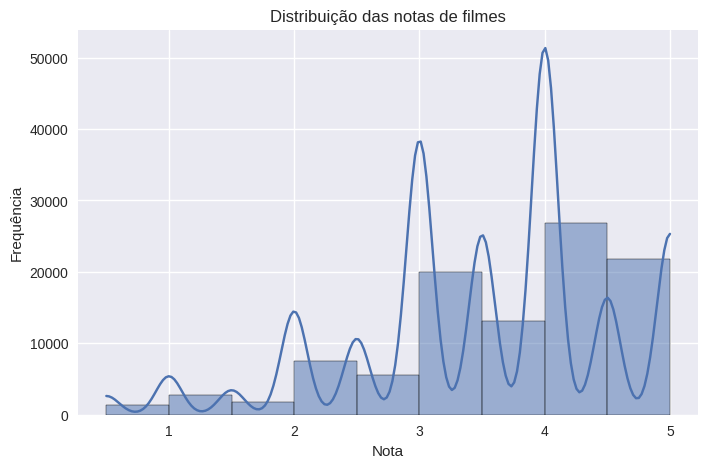

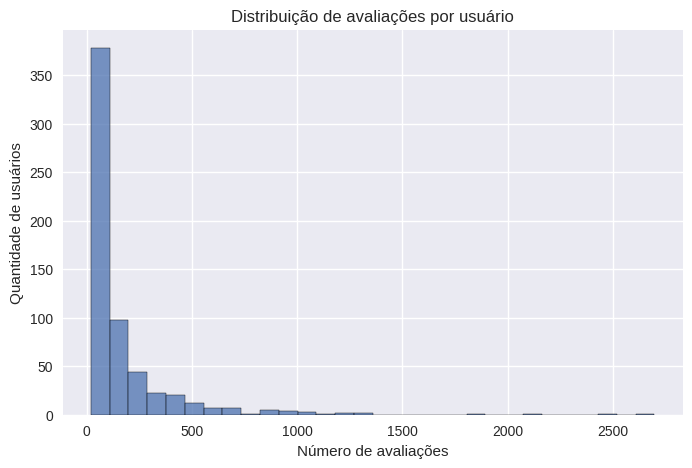

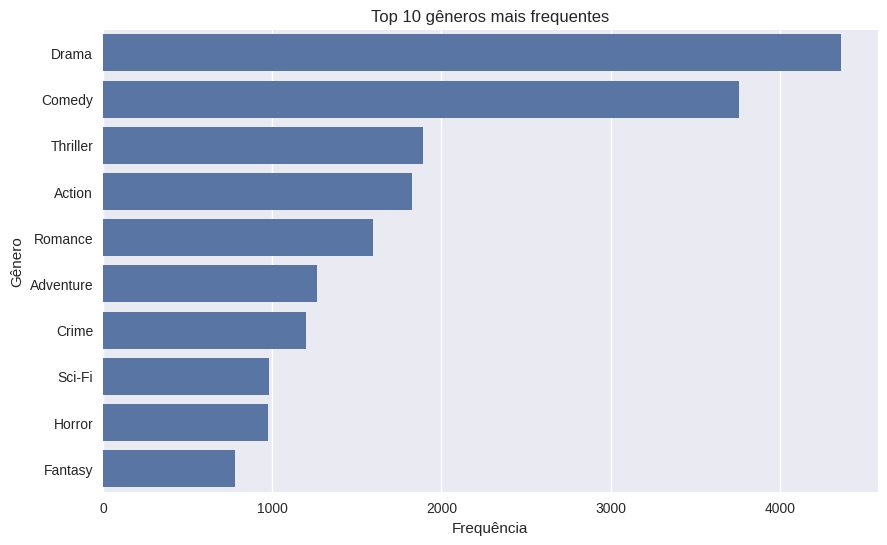

Sparsidade da matriz original: 98.30%
Tamanho da matriz filtrada: (501, 860)
📊 RMSE (KNN User-Based): 0.7991


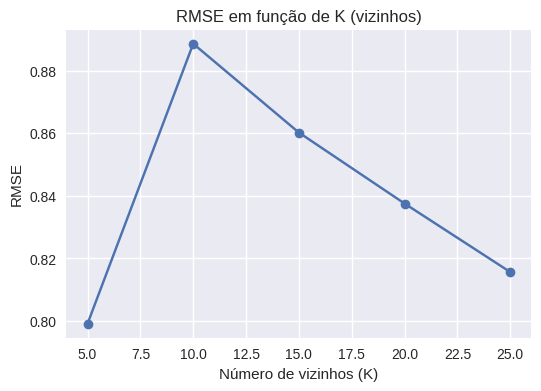


🎯 Recomendações para o usuário 414:
                                                  title  \
28    City of Lost Children, The (Cité des enfants p...   
930                                   Annie Hall (1977)   
943                                    Manhattan (1979)   
957                                 Shining, The (1980)   
1730         Life Is Beautiful (La Vita è bella) (1997)   

                                      genres  
28    Adventure|Drama|Fantasy|Mystery|Sci-Fi  
930                           Comedy|Romance  
943                     Comedy|Drama|Romance  
957                                   Horror  
1730                Comedy|Drama|Romance|War  


In [14]:

# -*- coding: utf-8 -*-
"""Sistema de Recomendação de Filmes com Filtragem Colaborativa (User-Based KNN)
Revisado conforme especificação do Trabalho Prático de Aprendizado de Máquina (2025-02)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# ===========================
# ETAPA 1 - Carregamento dos Dados
# ===========================

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")
tags = pd.read_csv("tags.csv")

print("📘 Tabelas carregadas:")
print(f"ratings: {ratings.shape}, movies: {movies.shape}, tags: {tags.shape}\n")

# Converter timestamp para datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')

# ===========================
# ETAPA 2 - Pré-processamento
# ===========================

print("Valores ausentes:")
print(ratings.isnull().sum())
ratings.dropna(inplace=True)

# Estatísticas básicas
describe = ratings['rating'].describe()
print("\nEstatísticas das notas:")
print(describe)

# ===========================
# ETAPA 3 - Análise Exploratória
# ===========================

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=9, kde=True)
plt.title("Distribuição das notas de filmes")
plt.xlabel("Nota")
plt.ylabel("Frequência")
plt.show()

ratings_per_user = ratings['userId'].value_counts()
plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user, bins=30)
plt.title("Distribuição de avaliações por usuário")
plt.xlabel("Número de avaliações")
plt.ylabel("Quantidade de usuários")
plt.show()

all_genres = movies['genres'].str.split('|').explode().value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=all_genres.head(10).values, y=all_genres.head(10).index)
plt.title("Top 10 gêneros mais frequentes")
plt.xlabel("Frequência")
plt.ylabel("Gênero")
plt.show()

# ===========================
# ETAPA 4 - Criação da Matriz Usuário-Item
# ===========================

user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
total_elements = user_item_matrix.shape[0] * user_item_matrix.shape[1]
filled_elements = user_item_matrix.count().sum()
sparsity = 1 - (filled_elements / total_elements)
print(f"Sparsidade da matriz original: {sparsity:.2%}")

# Filtrar usuários e filmes ativos
min_user_ratings = 30
min_movie_ratings = 30
active_users = ratings.groupby('userId').filter(lambda x: len(x) >= min_user_ratings)
active_movies = active_users.groupby('movieId').filter(lambda x: len(x) >= min_movie_ratings)
filtered_matrix = active_movies.pivot_table(index='userId', columns='movieId', values='rating')

print(f"Tamanho da matriz filtrada: {filtered_matrix.shape}")

# ===========================
# ETAPA 5 - Normalização e Treinamento KNN
# ===========================

# Normalizar notas por usuário
user_mean = filtered_matrix.mean(axis=1)
normalized_matrix = filtered_matrix.sub(user_mean, axis=0).fillna(0)

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(normalized_matrix.values)

# ===========================
# ETAPA 6 - Funções de Predição e Recomendação
# ===========================

def prever_nota_knn(user_id, movie_id, k=5):
    if movie_id not in normalized_matrix.columns or user_id not in normalized_matrix.index:
        return np.nan

    user_vector = normalized_matrix.loc[user_id].values.reshape(1, -1)
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=k+1)
    similar_users = indices.flatten()[1:]
    neighbor_dists = distances.flatten()[1:]

    neighbor_ratings = normalized_matrix.iloc[similar_users][movie_id]
    mask = neighbor_ratings != 0
    if mask.sum() == 0:
        return np.nan

    weights = 1 - neighbor_dists[mask]
    pred = np.dot(neighbor_ratings[mask], weights) / weights.sum()
    return pred + user_mean.loc[user_id]

def recomendar_filmes_knn(user_id, num_recomendacoes=5):
    if user_id not in normalized_matrix.index:
        print(f"Usuário {user_id} não está na base filtrada.")
        return pd.DataFrame()

    user_vector = normalized_matrix.loc[user_id].values.reshape(1, -1)
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=6)
    similar_users = indices.flatten()[1:]

    watched = filtered_matrix.loc[user_id].dropna().index.tolist()
    neighbor_ratings = filtered_matrix.iloc[similar_users]
    mean_ratings = neighbor_ratings.mean(axis=0)

    recommendations = mean_ratings.drop(watched).sort_values(ascending=False).head(num_recomendacoes)
    return movies[movies['movieId'].isin(recommendations.index)][['title', 'genres']]

# ===========================
# ETAPA 7 - Avaliação (RMSE)
# ===========================

# Criar split estratificado por usuário
ratings['user_bin'] = pd.qcut(ratings['userId'], q=10, duplicates='drop')
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(ratings, ratings['user_bin']):
    train_data = ratings.iloc[train_idx]
    test_data = ratings.iloc[test_idx]

train_matrix = train_data.pivot_table(index='userId', columns='movieId', values='rating')
train_matrix = train_matrix.reindex(index=filtered_matrix.index, columns=filtered_matrix.columns).fillna(0)
model_knn.fit(train_matrix.values)

# Avaliação RMSE
y_true, y_pred = [], []
sample_test = test_data.sample(500, random_state=42)
for _, row in sample_test.iterrows():
    pred = prever_nota_knn(row['userId'], row['movieId'], k=5)
    if not np.isnan(pred):
        y_true.append(row['rating'])
        y_pred.append(pred)

rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"📊 RMSE (KNN User-Based): {rmse:.4f}")

# ===========================
# ETAPA 8 - Resultados e Visualização
# ===========================

ks = [5, 10, 15, 20, 25]
rmses = []
for k in ks:
    preds, truths = [], []
    for _, row in sample_test.iterrows():
        pred = prever_nota_knn(row['userId'], row['movieId'], k=k)
        if not np.isnan(pred):
            preds.append(pred)
            truths.append(row['rating'])
    rmses.append(sqrt(mean_squared_error(truths, preds)))

plt.figure(figsize=(6,4))
plt.plot(ks, rmses, marker='o')
plt.title("RMSE em função de K (vizinhos)")
plt.xlabel("Número de vizinhos (K)")
plt.ylabel("RMSE")
plt.show()

# Exemplo de recomendação
print("\n🎯 Recomendações para o usuário 414:")
print(recomendar_filmes_knn(414, num_recomendacoes=5))


K= 5 -> RMSE=0.1885
K=10 -> RMSE=0.2559
K=15 -> RMSE=0.2945
K=20 -> RMSE=0.3124
K=25 -> RMSE=0.3266
K=30 -> RMSE=0.3509


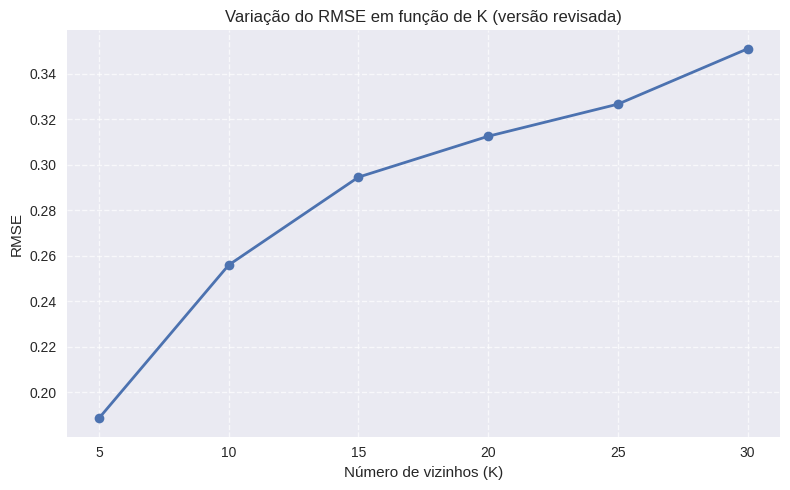

In [15]:
# =======================================================
# Gráfico: RMSE em função de K (versão revisada)
# =======================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances

# --- 1. Criar subconjunto da base filtrada e normalizada ---
ratings_filtered = filtered_matrix.copy()
user_mean = ratings_filtered.mean(axis=1)
ratings_norm = ratings_filtered.sub(user_mean, axis=0).fillna(0)

# --- 2. Definir função de predição KNN revisada ---
def predict_rating_knn(user_id, item_id, k=20):
    if item_id not in ratings_norm.columns:
        return np.nan

    user_vector = ratings_norm.loc[user_id].values.reshape(1, -1)
    distances = cosine_distances(user_vector, ratings_norm.values)[0]
    sim_users = ratings_norm.index[np.argsort(distances)[:k+1]]  # +1 inclui o próprio

    neighbor_dists = distances[np.argsort(distances)[:k+1]]
    weights = 1 - neighbor_dists
    mask = (ratings_norm.loc[sim_users, item_id] != 0)
    if not mask.any():
        return user_mean[user_id]

    pred = np.dot(weights[mask], ratings_norm.loc[sim_users[mask], item_id]) / weights[mask].sum()
    return pred + user_mean[user_id]

# --- 3. Avaliar RMSE para vários valores de K ---
Ks = [5, 10, 15, 20, 25, 30]
rmse_values = []

# Divisão estratificada simples (treino/teste)
train_users, test_users = train_test_split(ratings_norm.index, test_size=0.2, random_state=42)

for k in Ks:
    preds, trues = [], []
    for user in test_users[:50]:  # reduz amostra p/ performance
        rated_items = ratings_filtered.loc[user].dropna().index
        for item in np.random.choice(rated_items, min(5, len(rated_items)), replace=False):
            true_rating = ratings_filtered.loc[user, item]
            pred_rating = predict_rating_knn(user, item, k)
            if not np.isnan(pred_rating):
                preds.append(pred_rating)
                trues.append(true_rating)

    rmse = sqrt(mean_squared_error(trues, preds))
    rmse_values.append(rmse)
    print(f"K={k:2d} -> RMSE={rmse:.4f}")

# --- 4. Plotar e salvar figura ---
plt.figure(figsize=(8, 5))
plt.plot(Ks, rmse_values, marker='o', linewidth=2)
plt.title("Variação do RMSE em função de K (versão revisada)")
plt.xlabel("Número de vizinhos (K)")
plt.ylabel("RMSE")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("fig_rmse.png", dpi=300)
plt.show()
